In [1]:
# Custom libraries
from libraries.dataPreprocessing import *
from libraries.snnNetwork import *
from libraries.datasetLoader import *

# Pytorch imports
from torch.utils.data import DataLoader

# Matplotlib imports
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

# Parse .csv files
import pandas as pd

# Script options
import getopt
import sys

In [2]:
# File paths
sourceFile = './datasets/iris/iris.data'
saveFile = './processedData/iris.data'
networkFile = './networks/irisNetwork.pt'

In [3]:
# Data characteristics
variablePositions = [0, 1, 2, 3]
resultPosition = 4
resultEncoding = {
  "Iris-setosa": "0",
  "Iris-versicolor": "1",
  "Iris-virginica": "2"
}

# Number of steps

In [4]:
num_steps = 10


# 1. Iris Dataset information

SOURCE: https://archive.ics.uci.edu/dataset/53/iris 

FROM: iris.names

1. Number of Instances: 150 (50 in each of three classes)
2. Number of Attributes: 4 numeric, predictive attributes and the class
3. Attribute Information:
   1. sepal length in cm
   2. sepal width in cm
   3. petal length in cm
   4. petal width in cm
   5. class: 
      - Iris Setosa
      - Iris Versicolour
      - Iris Virginica
4. Missing Attribute Values: None

Summary Statistics:
|                   | Min | Max | Mean | SD   | Class Correlation |
|-------------------|-----|-----|------|------|-------------------|
| sepal length:     | 4.3 | 7.9 | 5.84 | 0.83 | 0.7826            |
| sepal width:      | 2.0 | 4.4 | 3.05 | 0.43 | -0.4194           |
| petal length:     | 1.0 | 6.9 | 3.76 | 1.76 | 0.9490   (high!)  |
| petal width:      | 0.1 | 2.5 | 1.20 | 0.76 | 0.9565   (high!)  |

5. Class Distribution: 33.3% for each of 3 classes.

# 2. No-Gaussian receptive fields


## 2.1. Processing Data
In `processData` method, `gaussian=False`.

In [5]:
# Read data
elementSeparator = '\n'
parameterSeparator = ','

In [6]:
print("Reading data: ", sourceFile)
rawData = readCSVData(sourceFile, elementSeparator, parameterSeparator)

Reading data:  ./datasets/iris/iris.data


In [7]:
# Process data
fieldSuperposition = 1.5 # Beta
nInputNeurons = 4 # Input neurons per parameter
nIntervals = 10

In [8]:
print(len(rawData[0]), ",", len(rawData))
print(type(rawData))
rawData[:2]

5 , 150
<class 'list'>


[['5.1', '3.5', '1.4', '0.2', 'Iris-setosa'],
 ['4.9', '3.0', '1.4', '0.2', 'Iris-setosa']]

As mentioned in Section 1, we have 4 parameters (min, max, mean, and standard deviation) for the iris dataset. Then, we are going to process the data using the **Gaussian Fields**.

In [9]:
# Example with no result interval calculation (directly write excitation)
processedData = processData(data=rawData, 
                            variablePositions=variablePositions, 
                            nInputNeurons=nInputNeurons, 
                            fieldSuperposition=fieldSuperposition,
                            add_results=True,
                            resultEncoding=resultEncoding,
                            resultPosition=resultPosition,
                            gaussian=False,
                            normalize=True,
                            )

In [10]:
print(len(processedData[0]), ",", len(processedData))
print(type(processedData))
processedData[:2]

5 , 150
<class 'list'>


[[0.22222222222222213,
  0.6249999999999999,
  0.06779661016949151,
  0.04166666666666667,
  '0'],
 [0.1666666666666668,
  0.41666666666666663,
  0.06779661016949151,
  0.04166666666666667,
  '0']]

The resulting data has the number of instances and the number of features equal to the previous dataset when using `gaussian = False`. Otherwise (`gaussian = True`), we obtain the same number of instances but the number of features are increased up to 16 (raw data has 4 features). However, if we have the same number of instances, **how can it be coded in time?**

In [11]:
# Save data
elementSeparator = '\n'
parameterSeparator = ','
writeCSVData(processedData, saveFile, elementSeparator, parameterSeparator, rearrange=True)

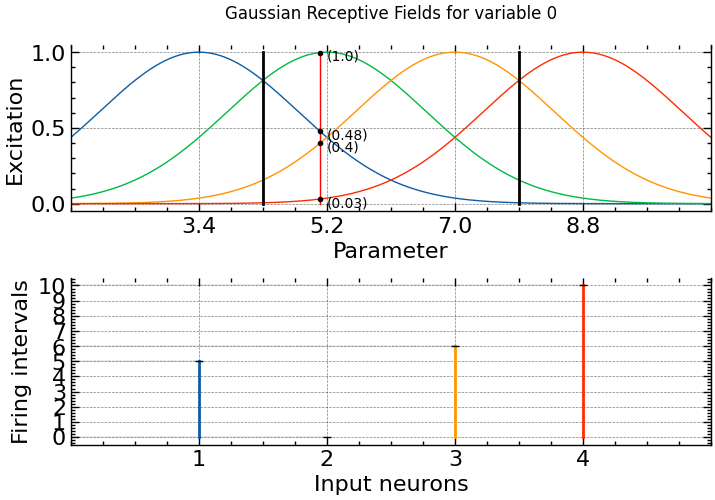

In [12]:
#How to plot a random data point (if Gaussian encoding is used)

figurePath = './figures/irisPlot.pdf'
fieldSuperposition = 1.5 # Beta
nInputNeurons = 4 # Input neurons per parameter
nIntervals = 10
elementToPlot = 0
parameterToPlot = 0

plotDataPoint(rawData, figurePath, fieldSuperposition, nInputNeurons, \
              nIntervals, elementToPlot, parameterToPlot)


## 2.2. Train and test LIF Network

In [13]:
# Network Architecture
num_inputs = len(variablePositions)
num_hidden = 16
num_outputs = len(resultEncoding)


In [14]:
# Definitions to load the network to cuda
batch_size = 5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [15]:
# Initialize datasets for training and testing
irisDataset_train =  CustomDataset(data_path=saveFile, train=True)
irisDataset_test =  CustomDataset(data_path=saveFile, train=False)

In [16]:
print("training instances: ",len(irisDataset_train), ", ", 100*len(irisDataset_train)/(len(irisDataset_train)+len(irisDataset_test)),"%")
print("test instances: ",len(irisDataset_test), ", ", 100*len(irisDataset_test)/(len(irisDataset_train)+len(irisDataset_test)),"%")

training instances:  105 ,  70.0 %
test instances:  45 ,  30.0 %


In [17]:
# Initialize data loaders  (drop last avoids having a last batch with fewer elements)
irisDataloader_train = DataLoader(irisDataset_train, batch_size=batch_size, drop_last=True)
irisDataloader_test = DataLoader(irisDataset_test, batch_size=batch_size, drop_last=True)

In [18]:
print("training batch instances: ",len(irisDataloader_train), ", total instances ", batch_size*len(irisDataloader_train))
print("test batch instances: ",len(irisDataloader_test), ", total instances ", batch_size*len(irisDataloader_test))

training batch instances:  21 , total instances  105
test batch instances:  9 , total instances  45


In [19]:
net = NetLIF(num_inputs, num_hidden, num_outputs, batch_size, num_steps).to(device) # Load the network onto CUDA if available

In [20]:
# Training variables
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
total = 0
correct = 0 

In [21]:
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(irisDataloader_train)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(spk_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print one out of every 100 computed values
        counter += 1
        if(counter % 100 == 0):  
            print(f"Train set loss: {loss_val.item()}")


Train set loss: 8.471696853637695
Train set loss: 8.270966529846191


In [22]:
with torch.no_grad():
    net.eval()
    count=0
    for data, targets in irisDataloader_test:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))
        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        if count==0:
            print("data: ", data, " shape ",data.shape)
            print("targets: ", targets, " shape ",targets.shape)
            print("test_spk: ", test_spk, " shape ",test_spk.shape)
            print("test_spk.sum(dim=0): ", test_spk.sum(dim=0))
            print("test_spk.sum(dim=0).max(1): ", test_spk.sum(dim=0).max(1))
            print("predicted: ", predicted)
        count+=1

print(f"Total correctly classified elements with LIF network: {correct}/{total}")
print(f"Test accuracy: {100 * correct / total:.2f}%")

data:  tensor([[0.2500, 0.2917, 0.4915, 0.5417],
        [0.1667, 0.4583, 0.0847, 0.0000],
        [0.7222, 0.5000, 0.7966, 0.9167],
        [0.4722, 0.3750, 0.5932, 0.5833],
        [0.5833, 0.5000, 0.5932, 0.5833]])  shape  torch.Size([5, 4])
targets:  tensor([1, 0, 2, 1, 1])  shape  torch.Size([5])
test_spk:  tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 1.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 1., 1.],
         [1., 0., 0.],
         [0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.]],

        [[0., 1., 1.],
         [1., 0., 0.],
         [0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 0.]],

        [[0., 1., 0.],
         [1., 0., 0.],
         [0., 1., 1.],
         [0., 1., 0.],
         

We have a batch of 5 instances. Each instance is passed through the network 10 times (`num_steps = 10`), so the result is a spike tensor of $10 \times 5 \times 3$ (10 sequences, 5 instances, and 3 ouputs). This spike tensor stores the stream of pulses for each instance. Then, they want to decode the ouput. They asume that the classification corresponds to the most activated output neuron. Therefore, they decode the stream of pulses by sum all the pulses up for each output neuron (`test_spk.sum(dim=0)`), and then comparing which is the output neuron most activated(`test_spk.sum(dim=0).max(1)`). **Is it the decoding method directly related to the training algorithm?**

In [23]:
# Save the model
torch.save(net.state_dict(), networkFile)

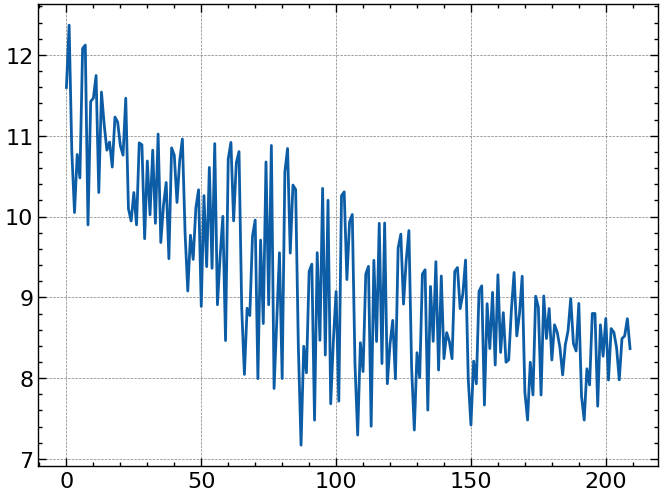

In [24]:
# Plot history loss of the model
plt.plot(loss_hist)
plt.show()

## 2.3. Test Izhikevich Network

In [25]:
# Initialize datasets for training and testing
irisDataset_test =  CustomDataset(data_path=saveFile, train=False)

In [26]:
# Initialize data loaders  (drop last avoids having a last batch with fewer elements)
irisDataloader_test = DataLoader(irisDataset_test, batch_size=batch_size, drop_last=True)


In [27]:
# Define new network
net = NetIzhi(num_inputs, num_hidden, num_outputs, batch_size, num_steps).to(device) # Load the network onto CUDA if available

print('Loading network: ', networkFile)
net.load_state_dict(torch.load(networkFile))

total = 0
correct = 0

print('Starting Izhikevich network evaluation')
with torch.no_grad():
    net.eval()
    for data, targets in irisDataloader_test:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified elements with Izhi network: {correct}/{total}")
print(f"Test accuracy: {100 * correct / total:.2f}%")

Loading network:  ./networks/irisNetwork.pt
Starting Izhikevich network evaluation


Total correctly classified elements with Izhi network: 16/45
Test accuracy: 35.56%


/tmp/ipykernel_228609/1581101135.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(networkFile))


In [28]:
# Define new network
net = NetIzhi(num_inputs, num_hidden, num_outputs, batch_size, num_steps).to(device) # Load the network onto CUDA if available

In [29]:
# Training variables
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
total = 0
correct = 0 

In [30]:
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(irisDataloader_train)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(spk_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print one out of every 100 computed values
        counter += 1
        if(counter % 100 == 0):  
            print(f"Train set loss: {loss_val.item()}")


Train set loss: 10.986122131347656
Train set loss: 10.729521751403809


In [31]:
with torch.no_grad():
    net.eval()
    for data, targets in irisDataloader_test:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified elements with LIF network: {correct}/{total}")
print(f"Test accuracy: {100 * correct / total:.2f}%")

Total correctly classified elements with LIF network: 29/45
Test accuracy: 64.44%


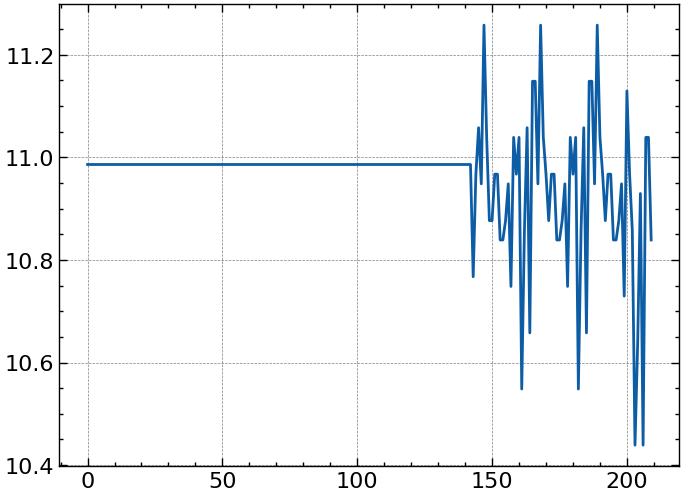

In [32]:
# Plot history loss of the model
plt.plot(loss_hist)
plt.show()

# 3. Gaussian receptive fields


## 3.1. Processing Data
In `processData` method, `gaussian=True`.

In [33]:
# Read data
elementSeparator = '\n'
parameterSeparator = ','

In [34]:
print("Reading data: ", sourceFile)
rawData = readCSVData(sourceFile, elementSeparator, parameterSeparator)

Reading data:  ./datasets/iris/iris.data


In [35]:
# Process data
fieldSuperposition = 1.5 # Beta
nInputNeurons = 4 # Input neurons per parameter
nIntervals = 10

In [36]:
print(len(rawData[0]), ",", len(rawData))
print(type(rawData))
rawData[:2]

5 , 150
<class 'list'>


[['5.1', '3.5', '1.4', '0.2', 'Iris-setosa'],
 ['4.9', '3.0', '1.4', '0.2', 'Iris-setosa']]

As mentioned in Section 1, we have 4 parameters (min, max, mean, and standard deviation) for the iris dataset. Then, we are going to process the data using the **Gaussian Fields**.

In [37]:
# Example with no result interval calculation (directly write excitation)
processedData = processData(data=rawData, 
                            variablePositions=variablePositions, 
                            nInputNeurons=nInputNeurons, 
                            fieldSuperposition=fieldSuperposition,
                            add_results=True,
                            resultEncoding=resultEncoding,
                            resultPosition=resultPosition,
                            gaussian=True,
                            normalize=True,
                            )

In [38]:
print(len(processedData[0]), ",", len(processedData))
print(type(processedData))
processedData[:2]

17 , 150
<class 'list'>


[[0.47843022549490544,
  0.42260044322318885,
  0.18256450679346922,
  0.9087337563610701,
  0.9974522306792803,
  0.8536763613451478,
  0.5717673437347538,
  0.9523447998951764,
  0.39815322221381244,
  0.9825754689579004,
  0.00039488917510926855,
  0.5686710537186722,
  0.030429372427211825,
  0.6443887248251954,
  6.014284846122268e-11,
  0.1934805816070468,
  '0'],
 [0.563279350501653,
  0.6065306597126334,
  0.18256450679346922,
  0.9087337563610701,
  0.9773023728519782,
  0.9692332344763441,
  0.5717673437347538,
  0.9523447998951764,
  0.3246524673583498,
  0.8824969025845953,
  0.00039488917510926855,
  0.5686710537186722,
  0.02064871806216111,
  0.4578333617716143,
  6.014284846122268e-11,
  0.1934805816070468,
  '0']]

As can be observed, the resulting data has the number of instances and the number of features equal to the previous dataset when using `gaussian = False`. Otherwise (`gaussian = True`), we obtain the same number of instances but the number of features are increased up to 16 (raw data has 4 features). However, if we have the same number of instances, **how can it be coded in time?**

In [39]:
# Save data
elementSeparator = '\n'
parameterSeparator = ','
writeCSVData(processedData, saveFile, elementSeparator, parameterSeparator, rearrange=True)

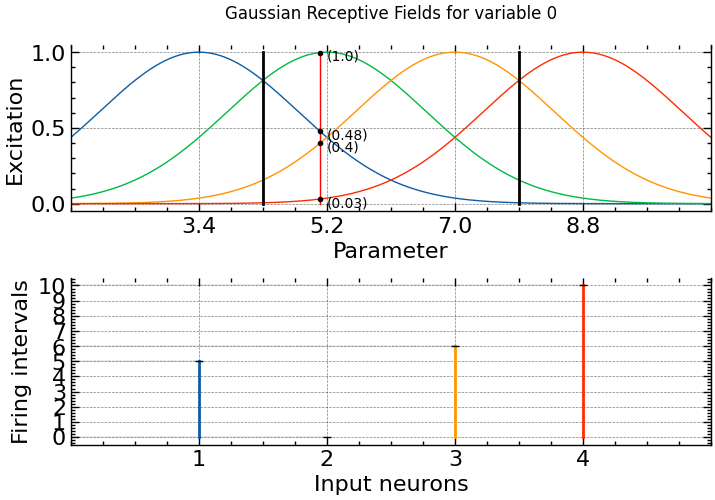

In [40]:
#How to plot a random data point (if Gaussian encoding is used)

figurePath = './figures/irisPlot.pdf'
fieldSuperposition = 1.5 # Beta
nInputNeurons = 4 # Input neurons per parameter
nIntervals = 10
elementToPlot = 0
parameterToPlot = 0

plotDataPoint(rawData, figurePath, fieldSuperposition, nInputNeurons, \
              nIntervals, elementToPlot, parameterToPlot)


## 3.2. Train and test LIF Network

In [41]:
# Network Architecture
num_inputs = len(processedData[0])-1
num_hidden = 16
num_outputs = len(resultEncoding)


In [42]:
# Definitions to load the network to cuda
batch_size = 5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [43]:
# Initialize datasets for training and testing
irisDataset_train =  CustomDataset(data_path=saveFile, train=True)
irisDataset_test =  CustomDataset(data_path=saveFile, train=False)

In [44]:
print("training instances: ",len(irisDataset_train), ", ", 100*len(irisDataset_train)/(len(irisDataset_train)+len(irisDataset_test)),"%")
print("test instances: ",len(irisDataset_test), ", ", 100*len(irisDataset_test)/(len(irisDataset_train)+len(irisDataset_test)),"%")

training instances:  105 ,  70.0 %
test instances:  45 ,  30.0 %


In [45]:
# Initialize data loaders  (drop last avoids having a last batch with fewer elements)
irisDataloader_train = DataLoader(irisDataset_train, batch_size=batch_size, drop_last=True)
irisDataloader_test = DataLoader(irisDataset_test, batch_size=batch_size, drop_last=True)

In [46]:
print("training batch instances: ",len(irisDataloader_train), ", total instances ", batch_size*len(irisDataloader_train))
print("test batch instances: ",len(irisDataloader_test), ", total instances ", batch_size*len(irisDataloader_test))

training batch instances:  21 , total instances  105
test batch instances:  9 , total instances  45


In [47]:
net = NetLIF(num_inputs, num_hidden, num_outputs, batch_size, num_steps).to(device) # Load the network onto CUDA if available

In [48]:
# Training variables
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
total = 0
correct = 0 

In [49]:
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(irisDataloader_train)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(spk_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print one out of every 100 computed values
        counter += 1
        if(counter % 100 == 0):  
            print(f"Train set loss: {loss_val.item()}")


Train set loss: 7.992953300476074
Train set loss: 6.827648162841797


In [50]:
with torch.no_grad():
    net.eval()
    for data, targets in irisDataloader_test:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified elements with LIF network: {correct}/{total}")
print(f"Test accuracy: {100 * correct / total:.2f}%")

Total correctly classified elements with LIF network: 42/45
Test accuracy: 93.33%


In [51]:
# Save the model
torch.save(net.state_dict(), networkFile)

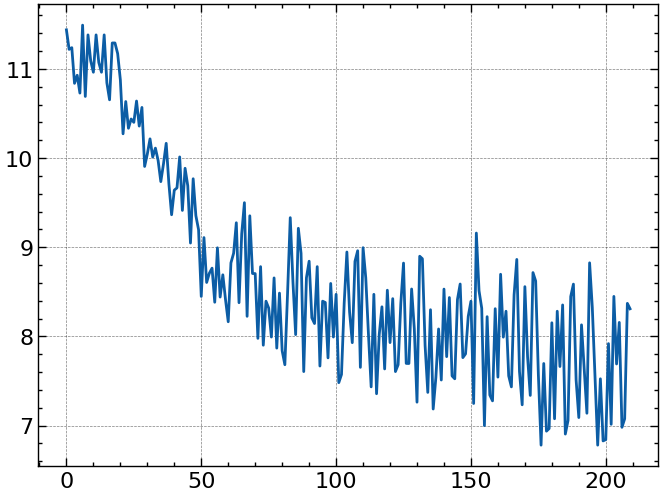

In [52]:
# Plot history loss of the model
plt.plot(loss_hist)
plt.show()

## 3.3. Test Izhikevich Network

In [53]:
# Initialize datasets for training and testing
irisDataset_test =  CustomDataset(data_path=saveFile, train=False)

In [54]:
# Initialize data loaders  (drop last avoids having a last batch with fewer elements)
irisDataloader_test = DataLoader(irisDataset_test, batch_size=batch_size, drop_last=True)


In [55]:
# Define new network
net = NetIzhi(num_inputs, num_hidden, num_outputs, batch_size, num_steps).to(device) # Load the network onto CUDA if available

print('Loading network: ', networkFile)
net.load_state_dict(torch.load(networkFile))

total = 0
correct = 0

print('Starting Izhikevich network evaluation')
with torch.no_grad():
    net.eval()
    for data, targets in irisDataloader_test:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified elements with Izhi network: {correct}/{total}")
print(f"Test accuracy: {100 * correct / total:.2f}%")

Loading network:  ./networks/irisNetwork.pt
Starting Izhikevich network evaluation
Total correctly classified elements with Izhi network: 18/45
Test accuracy: 40.00%


/tmp/ipykernel_228609/1581101135.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(networkFile))


In [56]:
# Define new network
net = NetIzhi(num_inputs, num_hidden, num_outputs, batch_size, num_steps).to(device) # Load the network onto CUDA if available

In [57]:
# Training variables
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
total = 0
correct = 0 

In [58]:
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(irisDataloader_train)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(spk_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print one out of every 100 computed values
        counter += 1
        if(counter % 100 == 0):  
            print(f"Train set loss: {loss_val.item()}")


Train set loss: 10.85782241821289
Train set loss: 10.438955307006836


In [59]:
with torch.no_grad():
    net.eval()
    for data, targets in irisDataloader_test:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified elements with LIF network: {correct}/{total}")
print(f"Test accuracy: {100 * correct / total:.2f}%")

Total correctly classified elements with LIF network: 29/45
Test accuracy: 64.44%


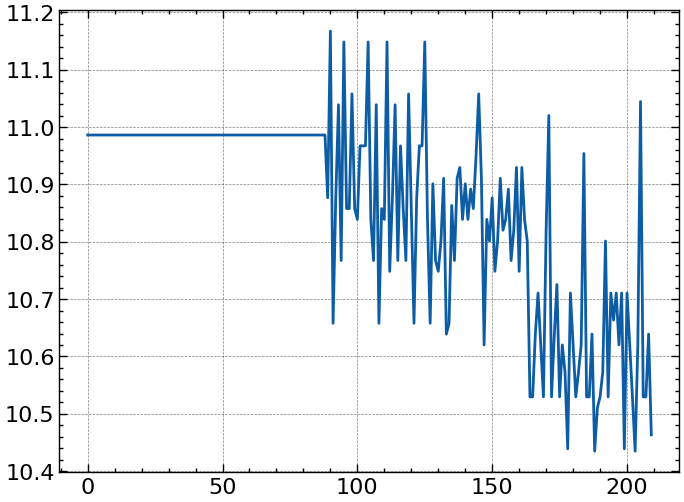

In [60]:
# Plot history loss of the model
plt.plot(loss_hist)
plt.show()

# 4. Raw Data-based

## 4.1. Processing Data

In [61]:
# Read data
elementSeparator = '\n'
parameterSeparator = ','

In [62]:
print("Reading data: ", sourceFile)
rawData = readCSVData(sourceFile, elementSeparator, parameterSeparator)

Reading data:  ./datasets/iris/iris.data


In [63]:
# Process data
fieldSuperposition = 1.5 # Beta
nInputNeurons = 4 # Input neurons per parameter
nIntervals = 10

In [64]:
print(len(rawData[0]), ",", len(rawData))
print(type(rawData))
rawData[:2]

5 , 150
<class 'list'>


[['5.1', '3.5', '1.4', '0.2', 'Iris-setosa'],
 ['4.9', '3.0', '1.4', '0.2', 'Iris-setosa']]

In [65]:
processedData=[]
for item in rawData:
    itemData=[]
    for element in item:
        if element=='Iris-setosa':
            itemData.append('0')
        elif element =='Iris-versicolor':
            itemData.append('1')
        elif element=='Iris-virginica':
            itemData.append('2')
        else:
            itemData.append(float(element))
    processedData.append(itemData)


In [66]:
print(len(processedData[0]), ",", len(processedData))
print(type(processedData))
processedData[:2]

5 , 150
<class 'list'>


[[5.1, 3.5, 1.4, 0.2, '0'], [4.9, 3.0, 1.4, 0.2, '0']]

In [67]:
# Save data
elementSeparator = '\n'
parameterSeparator = ','
writeCSVData(processedData, saveFile, elementSeparator, parameterSeparator, rearrange=True)

## 4.2. Train and test LIF Network

In [68]:
# Network Architecture
num_inputs = len(variablePositions)
num_hidden = 16
num_outputs = len(resultEncoding)

In [69]:
# Definitions to load the network to cuda
batch_size = 5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [70]:
# Initialize datasets for training and testing
irisDataset_train =  CustomDataset(data_path=saveFile, train=True)
irisDataset_test =  CustomDataset(data_path=saveFile, train=False)

In [71]:
print("training instances: ",len(irisDataset_train), ", ", 100*len(irisDataset_train)/(len(irisDataset_train)+len(irisDataset_test)),"%")
print("test instances: ",len(irisDataset_test), ", ", 100*len(irisDataset_test)/(len(irisDataset_train)+len(irisDataset_test)),"%")

training instances:  105 ,  70.0 %
test instances:  45 ,  30.0 %


In [72]:
# Initialize data loaders  (drop last avoids having a last batch with fewer elements)
irisDataloader_train = DataLoader(irisDataset_train, batch_size=batch_size, drop_last=True)
irisDataloader_test = DataLoader(irisDataset_test, batch_size=batch_size, drop_last=True)

In [73]:
print("training batch instances: ",len(irisDataloader_train), ", total instances ", batch_size*len(irisDataloader_train))
print("test batch instances: ",len(irisDataloader_test), ", total instances ", batch_size*len(irisDataloader_test))

training batch instances:  21 , total instances  105
test batch instances:  9 , total instances  45


In [74]:
net = NetLIF(num_inputs, num_hidden, num_outputs, batch_size, num_steps).to(device) # Load the network onto CUDA if available

In [75]:
# Training variables
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
total = 0
correct = 0 

In [76]:
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(irisDataloader_train)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)
        print("data ",data, " shape ",data.shape)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data)
        print("spk_rec ",spk_rec, " shape ",spk_rec.shape)
        print("targets ",targets, " shape ",targets.shape)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            print("spk_rec[step] ",spk_rec[step], " shape ",spk_rec[step].shape)

            loss_val += loss(spk_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print one out of every 100 computed values
        counter += 1
        if(counter % 100 == 0):  
            print(f"Train set loss: {loss_val.item()}")


data  tensor([[5.6000, 2.5000, 3.9000, 1.1000],
        [6.4000, 2.7000, 5.3000, 1.9000],
        [5.5000, 2.4000, 3.7000, 1.0000],
        [4.9000, 2.5000, 4.5000, 1.7000],
        [5.1000, 3.5000, 1.4000, 0.2000]])  shape  torch.Size([5, 4])
spk_rec  tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [1., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [1., 0., 0.],

In [77]:
with torch.no_grad():
    net.eval()
    for data, targets in irisDataloader_test:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified elements with LIF network: {correct}/{total}")
print(f"Test accuracy: {100 * correct / total:.2f}%")

Total correctly classified elements with LIF network: 31/45
Test accuracy: 68.89%


In [78]:
# Save the model
torch.save(net.state_dict(), networkFile)

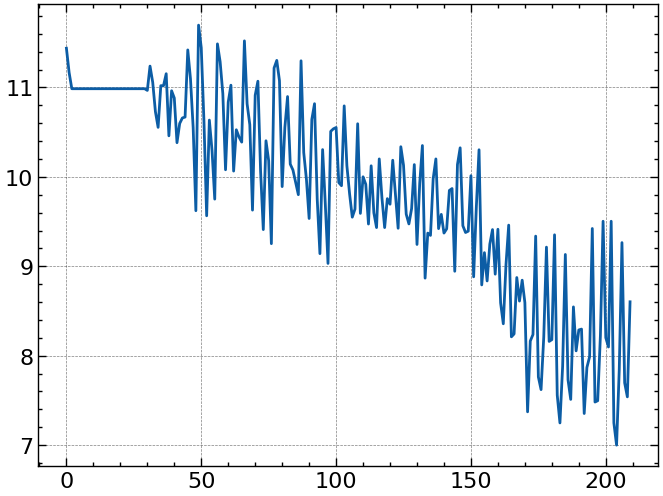

In [79]:
# Plot history loss of the model
plt.plot(loss_hist)
plt.show()

## 4.3. Test Izhikevich Network

In [80]:
# Initialize datasets for training and testing
irisDataset_test =  CustomDataset(data_path=saveFile, train=False)

In [81]:
# Initialize data loaders  (drop last avoids having a last batch with fewer elements)
irisDataloader_test = DataLoader(irisDataset_test, batch_size=batch_size, drop_last=True)


In [82]:
# Define new network
net = NetIzhi(num_inputs, num_hidden, num_outputs, batch_size, num_steps).to(device) # Load the network onto CUDA if available

print('Loading network: ', networkFile)
net.load_state_dict(torch.load(networkFile))

total = 0
correct = 0

print('Starting Izhikevich network evaluation')
with torch.no_grad():
    net.eval()
    for data, targets in irisDataloader_test:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified elements with Izhi network: {correct}/{total}")
print(f"Test accuracy: {100 * correct / total:.2f}%")

Loading network:  ./networks/irisNetwork.pt
Starting Izhikevich network evaluation
Total correctly classified elements with Izhi network: 20/45
Test accuracy: 44.44%


/tmp/ipykernel_228609/1581101135.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(networkFile))


In [83]:
# Define new network
net = NetIzhi(num_inputs, num_hidden, num_outputs, batch_size, num_steps).to(device) # Load the network onto CUDA if available

In [84]:
# Training variables
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
total = 0
correct = 0 

In [85]:
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(irisDataloader_train)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            print("spk_rec[step] ",spk_rec[step], " shape ",spk_rec[step].shape)
            loss_val += loss(spk_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print one out of every 100 computed values
        counter += 1
        if(counter % 100 == 0):  
            print(f"Train set loss: {loss_val.item()}")


spk_rec[step]  tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SelectBackward0>)  shape  torch.Size([5, 3])
spk_rec[step]  tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SelectBackward0>)  shape  torch.Size([5, 3])
spk_rec[step]  tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SelectBackward0>)  shape  torch.Size([5, 3])
spk_rec[step]  tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SelectBackward0>)  shape  torch.Size([5, 3])
spk_rec[step]  tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], grad_fn=<SelectBackward0>)  shape  torch.Size([5, 3])
spk_rec[step]  tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.

In [86]:
with torch.no_grad():
    net.eval()
    for data, targets in irisDataloader_test:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified elements with LIF network: {correct}/{total}")
print(f"Test accuracy: {100 * correct / total:.2f}%")

Total correctly classified elements with LIF network: 31/45
Test accuracy: 68.89%


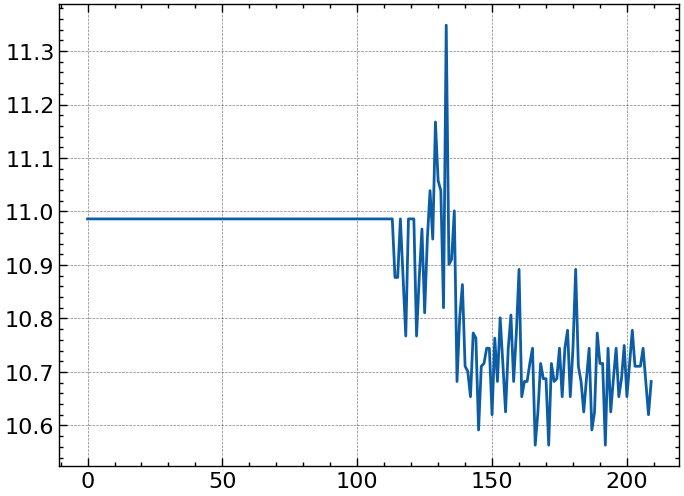

In [87]:
# Plot history loss of the model
plt.plot(loss_hist)
plt.show()